# Training a voice activity detection pipeline from scratch with `pyannote.audio`

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.  
In this tutorial, you will learn how to train and evaluate a VAD pipeline from scratch.

## Data preparation

This tutorial assumes that 
* the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/) has already been [setup for use with `pyannote`](https://github.com/pyannote/AMI-diarization-setup/tree/main/pyannote)
* the `PYANNOTE_DATABASE_CONFIG` environment variable is set accordingly. 

See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [2]:
from pyannote.database import get_protocol, FileFinder
preprocessors = {"audio": FileFinder()}
ami = get_protocol('AMI.SpeakerDiarization.only_words', 
                   preprocessors=preprocessors)

`pyannote.database` *protocols* usually define 
* a training set: `for training_file in protocol.train(): ...`, 
* a validation set: `for validation_file in protocol.development(): ...` 
* an evaluation set `for evaluation_file in protocol.test(): ...`

Let's listen to one minute of the first training file...

In [40]:
first_training_file = next(ami.train())
reference = first_training_file["annotation"]

In [72]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment
one_minute = Segment(240, 300)
listen(first_training_file, one_minute)

... and visualize the manual annotation:

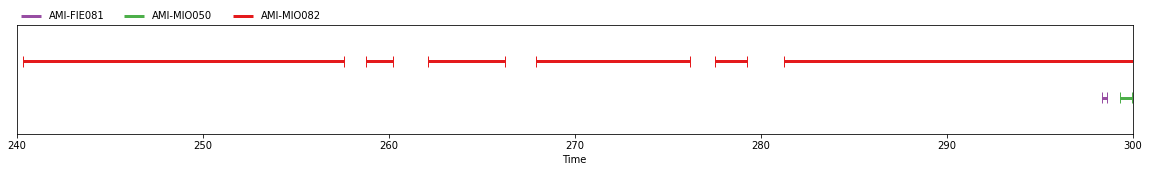

In [73]:
from pyannote.core import notebook
notebook.crop = one_minute
reference

## Training

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [17]:
from pyannote.audio.tasks import VoiceActivityDetection
vad = VoiceActivityDetection(ami, duration=2., batch_size=128)

We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad`) for which it is being trained:

In [20]:
from pyannote.audio.models.segmentation import PyanNet
model = PyanNet(sincnet={'stride': 10}, task=vad)

Now that everything is ready, let's train with `pytorch-ligthning`!

In [21]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=2)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | In sizes        | Out sizes                                        
-----------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet    | 42.6 K | [128, 1, 32000] | [128, 60, 115]                                   
1 | lstm              | LSTM       | 589 K  | [128, 115, 60]  | [[128, 115, 256], [[4, 128, 128], [4, 128, 128]]]
2 | linear            | ModuleList | 49.4 K | ?               | ?                                                
3 | classifier        | Linear     | 129    | [128, 115, 128] | [128, 115, 1]                                    
4 | activation        | Sigmoid    | 0      | [128, 115, 1]   | [128, 115, 1]                                    
5 | validation_metric | AUROC      | 0      

For the purpose of this tutorial, the model is trained for only 2 epochs. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

## Inference

Once trained, the model can be applied to a test file:

In [23]:
test_file = next(ami.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

In [29]:
from pyannote.audio import Inference
inference = Inference(model)
vad_probability = inference(test_file)

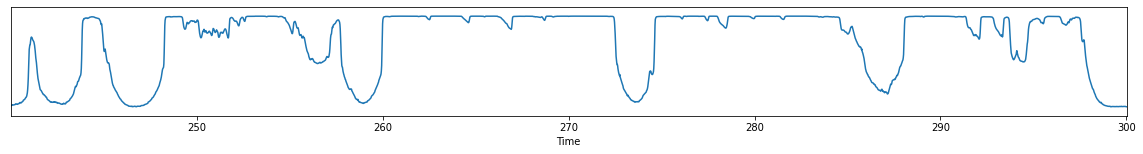

In [30]:
vad_probability

Perfect voice activity detection output should look like that:

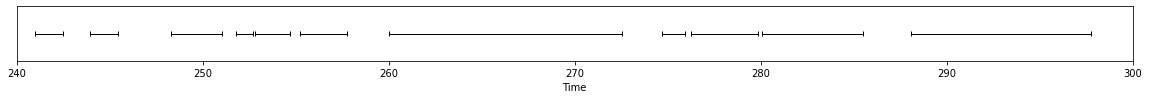

In [34]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [56]:
from pyannote.audio.pipelines import VoiceActivityDetection as VoiceActivityDetectionPipeline
pipeline = VoiceActivityDetectionPipeline(segmentation=model)
initial_params = {"onset": 0.6, "offset": 0.4, 
                  "min_duration_on": 0.0, "min_duration_off": 0.0}
pipeline.instantiate(initial_params)

Here we go:

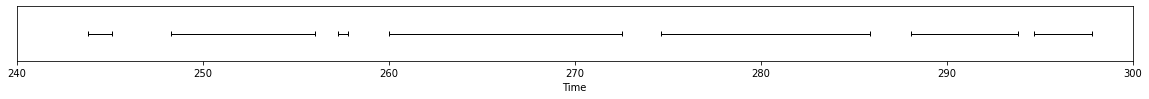

In [76]:
pipeline(test_file).get_timeline()

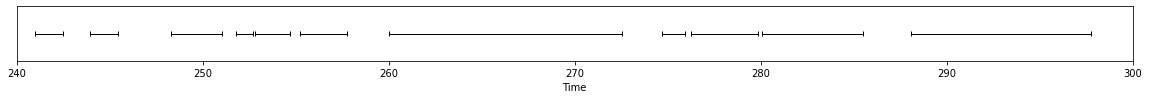

In [77]:
expected_output

Looks decent! Let's perform a proper evaluation by computing the [detection error rate](https://pyannote.github.io/pyannote-metrics/reference.html#detection) over the whole AMI test set:

In [54]:
from pyannote.metrics.detection import DetectionErrorRate
metric = DetectionErrorRate()

for file in ami.test():
    
    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],     # this is the reference annotation
        speech,                 # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated
    
# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 7.3%


## Optimizing pipeline hyper-parameters

While good enough, the hyper-parameters that we chose manually, we can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [60]:
pipeline.freeze({'min_duration_on': 0.0, 'min_duration_off': 0.0})

In [63]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()), 
               warm_start=initial_params, 
               n_iterations=20, 
               show_progress=False)

optimized_params = optimizer.best_params

There you go: better hyper-parameters that (should) lead to better results!

In [78]:
print(optimized_params)

{'onset': 0.8020095763639215, 'offset': 0.5643079355945013, 'min_duration_on': 0.0, 'min_duration_off': 0.0}


Let's evaluate the voice activity detection pipeline with this new set of hyper-parameters:

In [79]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = DetectionErrorRate()

for file in ami.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])
    
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 6.9%


🎉 Yeay! 5% relativement improvement simply by tuning the thresholds.